<h3> Bounding Boxes </h3>

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
files_in_dir = os.listdir()
dogcatimg = os.path.join(os.getcwd(),files_in_dir[1])
dogcatimg

'c:\\Users\\ASUS\\Desktop\\Hands on ML\\Hands-on-Machine-Learning-Textbook-Exercises\\DeepLearning_1\\Images\\dogcat.JPG'

In [3]:
dogcatimg_pixels = tf.io.decode_image(tf.io.read_file(dogcatimg))
#276,361,3

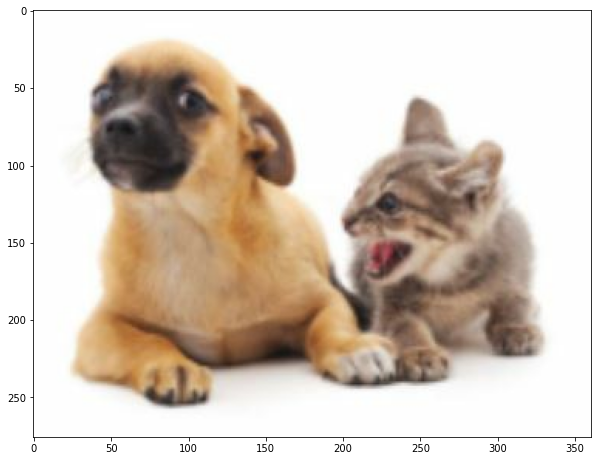

In [4]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(dogcatimg_pixels)

In [5]:
#upper_left, bottom_right
dog_box = [25.0,25.0,200.0,250.0]
cat_box = [200.0,50.0,330.0,225.0]

In [6]:
def box_corner_to_center(boxes):
    #upper_left
    x1 = boxes[0]
    y1 = boxes[1]
    #bottom_right
    x2 = boxes[2]
    y2 = boxes[3]
    centerx = (x1 + x2)/2
    centery = (y1 + y2)/2
    width = abs(x1 - x2)
    height = abs(y1 - y2)
    boxes = tf.stack((centerx,centery,width,height),axis = -1)
    return boxes

def box_center_to_corner(boxes):
    centerx = boxes[0]
    centery = boxes[1]
    width = boxes[2]
    height = boxes[3]
    #center to upper_left
    x1 = centerx - (width/2)
    y1 = centery - (height/2)
    #center to bottom_right
    x2 = centerx + width/2
    y2 = centery + (height/2)
    boxes = tf.stack((x1,y1,x2,y2),axis = -1)
    return boxes

In [7]:
boxes = tf.constant((dog_box,cat_box))
boxes

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 25.,  25., 200., 250.],
       [200.,  50., 330., 225.]], dtype=float32)>

In [8]:
center = tf.map_fn(box_corner_to_center,elems = boxes)
corners = tf.map_fn(box_center_to_corner,elems = center)

In [9]:
def box_to_rect(box,color):
    return plt.Rectangle(xy = (box[0],box[1]),width = box[2]-box[0],
                         height = box[3] - box[1],fill = False, edgecolor = color,linewidth = 2)

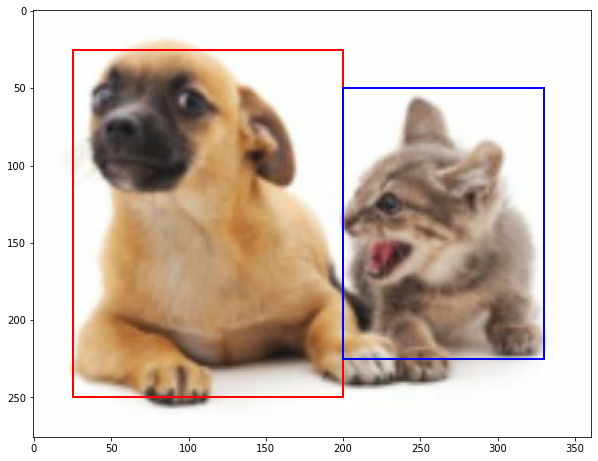

In [10]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(dogcatimg_pixels)
ax.add_patch(box_to_rect(dog_box,color = 'red'))
ax.add_patch(box_to_rect(cat_box,color = 'blue'))

<h3>Anchor Boxes</h3>

Object detection algorithms usually sample a large number of regions in an input image, determine whether these regions contain objects of interest and adjust the boundaries of the regions so as to predict the **ground truth bounding boxes** of the objects more accurately. 

There are different region sampling methods. Here we generate multiple bounding boxes with varying scales and aspect ratios centered on each pixel.

<h3>Generating multiple anchor boxes</h3>

Suppose the input image has a height of h and width of w. We generate anchor boxes with different shapes centered on each pixel. Scale (s) is between 0 to 1 and the aspect ratio(r)(ratio of width to height) is greater than 0. Width and height of the boxes are (ws(sqrt(r))) and (hs/(sqrt(r))). 

To generate multiple anchor boxes, we set up a series of scales s, and a series of aspect ratios r.

In [61]:
#generate multiple anchor boxes
def multibox_prior(data,sizes,ratios):
    #size and ratios are user specified
    in_height,in_width = data.shape[1],data.shape[2]
    devide,num_sizes,num_ratios = data.device,len(sizes),len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    sizes_tensor = tf.identity(sizes)
    ratios_tensor = tf.identity(ratios)
    offset_h,offset_w = 0.5,0.5
    steps_h = 1.0/in_height
    steps_w = 1.0/in_width

    #generating centerpoints for anchor boxes
    centers_h = tf.identity((np.arange(in_height) + offset_h)) * steps_h
    centers_w = tf.identity((np.arange(in_width) + offset_w)) * steps_w
    #create a meshgrid of centers
    mesh_x,mesh_y = tf.meshgrid(centers_w,centers_h)
    shift_x,shift_y = tf.experimental.numpy.reshape(mesh_x,newshape=-1),tf.experimental.numpy.reshape(mesh_y,newshape=-1)
    w = tf.concat([sizes_tensor * tf.math.sqrt(ratios_tensor[0]),sizes[0]*tf.math.sqrt(ratios_tensor[1:])],axis = 0)*(in_height/in_width)
    h = tf.concat([sizes_tensor / tf.math.sqrt(ratios_tensor[0]),sizes_tensor[0]/tf.math.sqrt(ratios_tensor[1:])],axis = 0)
    #repeats each manipulation combination to height*width combination
    #anchor_manipulations = tf.tile(tf.transpose(tf.stack((-w,-h,w,h))),repeats = (in_height*in_width),axis = 0)/2
    
    #repeat the centers for the number of combinations of unique s and r (only s1,r1) (this repeats each block of center combinations for boxes_per_pixel times)
    out_grid = tf.cast(tf.repeat(tf.stack([shift_x,shift_y,shift_x,shift_y],axis = 1),repeats = boxes_per_pixel,axis = 0),'float32')
    num_multiples = int(len(out_grid)/boxes_per_pixel)
    anchor_manipulations = tf.tile(tf.transpose(tf.stack((-w,-h,w,h))),multiples = [num_multiples,1])/2    

    output = out_grid + anchor_manipulations
    #return with batch axis added to result
    return tf.expand_dims(output,axis = 0)
    #return out_grid,anchor_manipulations

In [62]:
X = tf.random.uniform(shape=(1, 10, 10, 3)) 

In [63]:
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1.0, 2.0, 0.5])

The resulting output Y is of shape (batch_size,number of anchor boxes, 4)

After changing it to shape (image_height, image_width,number_of_anchor_boxes,4)

In [64]:
anchor_boxes_per_pixel = tf.experimental.numpy.reshape(Y,newshape = (10,10,5,4))

In [65]:
#anchor boxes centered on the first pixel
list(enumerate(anchor_boxes_per_pixel[0,0,:,:]))[0][1].numpy()

array([-0.325, -0.325,  0.425,  0.425], dtype=float32)

In [66]:
def show_anchorboxes(axes,anchor_boxes,img,labels = None, colors = None):
    def make_list(obj,default = None):
        if obj == None:
            obj = default
        elif not isinstance(obj,(list,tuple)):
            obj = [obj]
        return obj
    
    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    axes.imshow(img)
    for i,anchor_bx in enumerate(anchor_boxes):
        color = colors[i%len(colors)]
        box = anchor_bx
        patch = plt.Rectangle(xy = (box[0],box[1]),width = box[2]-box[0],
        height = box[3] - box[1],fill = False, edgecolor = color,linewidth = 2)
        axes.add_patch(patch)
        


In [67]:
w,h,c = dogcatimg_pixels.shape
print(w)
print(h)

276
361


In [68]:
scale = tf.cast(tf.identity((w,h,w,h)),'float32')
scale

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([276., 361., 276., 361.], dtype=float32)>

In [69]:
X = tf.random.uniform(shape=(1, w, h, 3)) 
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1.0, 2.0, 0.5])
Y.shape

TensorShape([1, 498180, 4])

In [72]:
anchor_boxes_per_pixel = tf.experimental.numpy.reshape(Y,newshape = (w,h,5,4))
anchor_boxes_per_pixel[200,200,:,:] * scale

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[ 74.160675, 126.87318 , 232.42105 , 397.62317 ],
       [100.5374  , 171.99818 , 206.04434 , 352.49817 ],
       [126.91413 , 217.12318 , 179.6676  , 307.37317 ],
       [ 41.38388 , 166.52359 , 265.19785 , 357.97278 ],
       [ 97.33737 ,  70.799   , 209.24435 , 453.6974  ]], dtype=float32)>

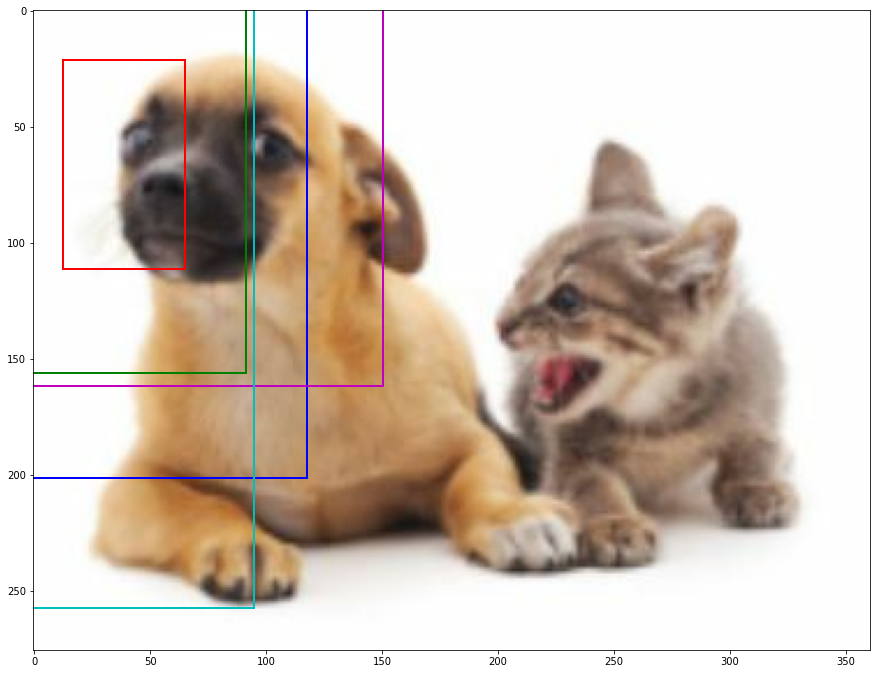

In [78]:
fig_anchor,ax_anchor = plt.subplots(1,1,figsize = (15,15))
show_anchorboxes(ax_anchor,anchor_boxes_per_pixel[50,50,:,:] * scale,dogcatimg_pixels)

<h3> Intersection over Union </h3>

Jaccard Index : Given 2 sets, it is the ratio between the intersection of the 2 sets divided by the union of the 2 sets. 

We can consider the pixel area of any bounding box as a set of pixels. This way we can measure the similarity of the two bounding boxes by the Jaccard index. For two bounding boxes, we usually refer to their Jazzard index as Intersection over Union. Range of IoU is between 0 and 1. 0 means no overlap, 1 means complete overlap. 

In [ ]:
def box_iou(boxes1,boxes2):
    def calc_box_area(box):
        area = (box[:,2] - box[:,0])*(box[:,3] - box[:,1])
    
    areas1 = calc_box_area(boxes1)
    areas2 = calc_box_area(boxes2)

    


In [89]:
test = anchor_boxes_per_pixel[200,200,:,:] * scale
test

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[ 74.160675, 126.87318 , 232.42105 , 397.62317 ],
       [100.5374  , 171.99818 , 206.04434 , 352.49817 ],
       [126.91413 , 217.12318 , 179.6676  , 307.37317 ],
       [ 41.38388 , 166.52359 , 265.19785 , 357.97278 ],
       [ 97.33737 ,  70.799   , 209.24435 , 453.6974  ]], dtype=float32)>

In [91]:
tf.expand_dims(test[0],axis = 0)[:,:2]

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 74.160675, 126.87318 ]], dtype=float32)>

In [92]:
tf.expand_dims(test[0],axis = 0)[:,2:]

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[232.42105, 397.62317]], dtype=float32)>

In [93]:
tf.math.maximum(tf.expand_dims(test[0],axis = 0)[:,:2],tf.expand_dims(test[0],axis = 0)[:,2:])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[232.42105, 397.62317]], dtype=float32)>